<a href="https://colab.research.google.com/github/tranmanhcuong253/Vietnamese-RAG-Chatbot/blob/main/Vietnamese_RAG_Chatbot_Backend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 0.Packages


In [ ]:
%pip install ipython-autotime
%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 6.9 MB/s eta 0:00:00
time: 583 µs (started: 2024-12-14 10:16:55 +00:00)


In [ ]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

time: 769 ms (started: 2024-12-14 10:16:55 +00:00)


# 1.Static mapping table


## System prompt template


In [ ]:
SYS_PROMPT_TPL: str = '\n'.join([
    ("You are an assistant specialized in interpreting divination results. "
     "Use the following [Context] to provide insights and advice to users based on their questions. "
     "Always format your responses according to the [Response Format] below, "
     "ensuring personalized interpretations and actionable advice."),
    "\n",
    "[Response Format] ",
    "您抽到的籤是: [Include 籤名 here] ",
    "籤詩: [Include full 籤詩 here] ",
    "\n",
    "籤詩解讀: ",
    "\n",
    "小廟公建議: ",
    "[Context] "
    "{context}"
    "\n"
    "Guidelines: "
    "- Interpret the provided [Context] flexibly. The \"籤詩解讀\" should connect the content of the divination with the user's question. "
    "- Use the \"小廟公建議\" to provide specific, actionable guidance relevant to the question, referencing details from the context where appropriate. "
    "- End with a short phrase encouraging the user, alike \"Don't worry\", \"Good luck\", etc. "
    "\n"
    "Note: "
    "If the length of the [Context] is less than 20 characters, provide the full [Context] directly as a response without applying the [Response Format]."
])

print(SYS_PROMPT_TPL)

You are an assistant specialized in interpreting divination results. Use the following [Context] to provide insights and advice to users based on their questions. Always format your responses according to the [Response Format] below, ensuring personalized interpretations and actionable advice.


[Response Format] 
您抽到的籤是: [Include 籤名 here] 
籤詩: [Include full 籤詩 here] 


籤詩解讀: 


小廟公建議: 
[Context] {context}
Guidelines: - Interpret the provided [Context] flexibly. The "籤詩解讀" should connect the content of the divination with the user's question. - Use the "小廟公建議" to provide specific, actionable guidance relevant to the question, referencing details from the context where appropriate. - End with a short phrase encouraging the user, alike "Don't worry", "Good luck", etc. 
Note: If the length of the [Context] is less than 20 characters, provide the full [Context] directly as a response without applying the [Response Format].
time: 2.57 ms (started: 2024-12-16 02:21:46 +00:00)


## RAG context template


In [ ]:
RAG_TPL: str = '\n'.join([
    "籤名: 【{吉凶}】{詩運} {籤名}-{詩名} ",
    "\n",
    "~籤詩~ ",
    "{籤詩}",
    "\n",
    "{詳解}",
    "\n",
    "小廟公建議可參考聖意如下, 不需要全數給求籤者, 若有任何難或不利的訊號, 則建議小心慎重, 正向訊號則可達成! ",
    "{聖意}",
    "\n",
    "潛在的指示為地支「{地支}」, 也可給求籤者做相關提醒: ",
    " - 地理位置代表{方位} ",
    " - 時間為{時間} ",
    " - 十二生肖對應為{生肖}, {生肖特色}, {生肖從事} ",
    " - 五行為「{五行}」, {五行}生{相生}但{五行}剋{相剋}, 若為上籤宜{五行上籤}等, 若為下籤則注意{五行下籤}等 ",
])

print(RAG_TPL)

## Mapping Table

籤詩, 地支, 五行, 時辰, 方位, 生肖..

統計: 大吉籤 8 支, 上吉籤 2 支, 上上籤 28 支, 上中籤 4 支, 上平籤 3 支, 上籤 1 支, 中吉、中上、中中、中平、中這個等級類別的籤共 25 支, 平中籤、平平籤、平籤各 1 支, 無標示的籤 25 支, 下下籤 1 支
加起來 100 支籤詩, 共 16 個吉凶的等級分類。
By [關於聖意] https://vocus.cc/article/60cc311efd8978000139e6c2

![](https://s1.astrologs.net/489fa60ffe094cb6b9e431d29164129c332507.jpg)
![](https://s1.astrologs.net/00863e956d804118b14f7761085abdaf643933.jpg)
![](https://s1.astrologs.net/7b135058418e40c2ad656470a47d0135244692.jpg)
![](https://s1.astrologs.net/639bd26c3de946f5876a2df721175f3b511769.jpg)
By [星玄説](https://astrologs.net/a/9kog8bd821/)


In [ ]:
# 籤詩數據
TOTAL_LOTS = 100
UNKNOWN_LOT_RESULT = '__'  # 詩運
DEFAULT_RESULT_GROUP = '中籤'
LOT_RESULT_GROUPs = ['上籤', '中籤', '下籤']
LOT_12_ZIs = ['丑宮', '亥宮', '午宮', '卯宮', '子宮', '寅宮',
              '巳宮', '戌宮', '未宮', '申宮', '辰宮', '酉宮']
LOT_RESULTs = ['__',  # unknown
               '大吉', '上吉', '上上', '上中', '上平', '上',
               '中吉', '中上', '中中', '中平', '中',
               '平中', '平平', '平',
               '下', '下下']
LOT_RESULT_MAP = dict(
    __='中籤',  # unknown
    大吉='上籤',
    上吉='上籤',
    上上='上籤',
    上中='上籤',
    上平='上籤',
    上='上籤',
    中吉='中籤',
    中上='中籤',
    中中='中籤',
    中平='中籤',
    中='中籤',
    平中='中籤',
    平平='中籤',
    平='中籤',
    下='下籤',
    下下='下籤',
)

# 定義地支、生肖和五行的對應關係
ZIs = ['子', '丑', '寅', '卯', '辰', '巳', '午', '未', '申', '酉', '戌', '亥']

# FiveElement 五行
ELEMENTs = ['金', '木', '水', '火', '土']

# 相生 相剋
ELEMENT_CYCLE_MAP = dict(
    金={'生': '水', '剋': '木'},
    木={'生': '火', '剋': '土'},
    水={'生': '木', '剋': '火'},
    火={'生': '土', '剋': '金'},
    土={'生': '金', '剋': '水'},
)

# 地支 - 生肖
ZI_ZODIAC_MAP = dict(
    子='鼠',
    丑='牛',
    寅='虎',
    卯='兔',
    辰='龍',
    巳='蛇',
    午='馬',
    未='羊',
    申='猴',
    酉='雞',
    戌='狗',
    亥='豬'
)

# 地支 - 五行
ZI_ELEMENT_MAP = dict(
    子='水',
    丑='土',
    寅='木',
    卯='木',
    辰='土',
    巳='火',
    午='火',
    未='土',
    申='金',
    酉='金',
    戌='土',
    亥='水'
)

# 地支 - 四季
ZI_SEASON_MAP = dict(
    子='冬',
    丑='四季',
    寅='春',
    卯='春',
    辰='四季',
    巳='夏',
    午='夏',
    未='四季',
    申='秋',
    酉='秋',
    戌='四季',
    亥='冬'
)

# 地支 - 方位,時辰
ZI_LOC_MAP = dict(
    子={'location': '北方', 'time': '晚上11點至凌晨1點'},
    丑={'location': '東北', 'time': '凌晨1點至3點'},
    寅={'location': '東北', 'time': '凌晨3點至5點'},
    卯={'location': '東方', 'time': '早上5點至7點'},
    辰={'location': '東南', 'time': '早上7點至9點'},
    巳={'location': '東南', 'time': '上午9點至11點'},
    午={'location': '南方', 'time': '中午11點至下午1點'},
    未={'location': '西南', 'time': '下午1點至3點'},
    申={'location': '西南', 'time': '下午3點至5點'},
    酉={'location': '西方', 'time': '下午5點至7點'},
    戌={'location': '西北', 'time': '晚上7點至9點'},
    亥={'location': '西北', 'time': '晚上9點至11點'},
)

# 生肖
ZODIACs = ['龍', '兔', '馬', '牛', '蛇', '豬', '羊', '猴', '狗', '鼠', '虎', '雞']

# 生肖 - 個性, 從事
ZODIAC_ATTR_MAP = dict(
    鼠={'personalities': ['機智', '靈活'], 'works': ['適合從事需要快速反應的工作']},
    牛={'personalities': ['勤奮', '穩重'], 'works': ['適合從事需要耐力和毅力的工作']},
    虎={'personalities': ['勇敢', '冒險'], 'works': ['適合從事需要勇氣和決斷力的工作']},
    兔={'personalities': ['溫和', '謹慎'], 'works': ['適合從事需要細心和耐心的工作']},
    龍={'personalities': ['自信', '領導'], 'works': ['適合從事需要創新和領導力的工作']},
    蛇={'personalities': ['智慧', '神秘'], 'works': ['適合從事需要策略和洞察力的工作']},
    馬={'personalities': ['熱情', '奔放'], 'works': ['適合從事需要活力和創意的工作']},
    羊={'personalities': ['溫柔', '善良'], 'works': ['適合從事需要關懷和同理心的工作']},
    猴={'personalities': ['聰明', '機智'], 'works': ['適合從事需要靈活和創意的工作']},
    雞={'personalities': ['勤奮', '細心'], 'works': ['適合從事需要細心和耐心的工作']},
    狗={'personalities': ['忠誠', '可靠'], 'works': ['適合從事需要信任和責任感的工作']},
    豬={'personalities': ['樂觀', '豁達'], 'works': ['適合從事需要樂觀和積極性的工作']},
)

# 五行 - goods, bads
ELEMENT_ADVICE = dict(
    金={
        '上籤': ['金融投資', '金屬工藝', '珠寶首飾', '學習理財', '健身鍛煉'],
        '下籤': ['過度消費', '金屬傷害', '金融風險', '過度勞累']
    },
    木={
        '上籤': ['園藝種植', '森林散步', '學習新知識', '創意工作', '綠色環保'],
        '下籤': ['過度勞累', '木製品傷害', '過度依賴', '環境污染']
    },
    水={
        '上籤': ['旅行', '水邊活動', '游泳', '學習水性', '水療按摩'],
        '下籤': ['游泳風險', '水邊活動安全', '過度飲水', '水污染']
    },
    火={
        '上籤': ['烹飪', '熱情工作', '學習新技能', '社交活動', '創意表達'],
        '下籤': ['高溫環境', '火災風險', '過度熱情', '火氣過旺']
    },
    土={
        '上籤': ['土地耕作', '建築設計', '學習歷史', '穩定工作', '家庭聚會'],
        '下籤': ['過度勞累', '土石傷害', '過度保守', '環境破壞']
    }
)

LOT_CONTEXT_KEYS = ['籤名', '詩名', '詩運', '籤詩', '吉凶', '宮位',
                    '詩意', '解曰', '淺釋', '靈籤', '詳解']

LOT_PURPOSE_KEYS = [
    "家宅",
    "自身",
    "求財",
    "交易",
    "婚姻",
    "六甲",
    "行人",
    "田蠶",
    "六畜",
    "尋人",
    "公訟",
    "移徙",
    "失物",
    "疾病",
    "山墳"
]

LOT_PURPOSE_ANSWERS = dict(
    家宅={'欠安（大吉）', '先凶后吉', '旺', '大利', '安', '慎出', '利', '平常', '損失', '吉', '若前', '祈保（吉）', '不安', '許願', '口舌', '還願', '不利',
        '守舊', '欠安', '大吉', '祈保', '清吉', '平安', '欠利', '平吉', '心只', '憂疑', '中平', '平平', '祈福', '作福', '吉利', '凶', '亂', '不利（漸安）'},
    自身={'困滯', '順利', '康泰', '安', '路行', '許經', '平常', '災耗', '秋冬大利', '秋冬旺', '還願（大吉）', '欠吉（凶。注意健康）', '吉', '平', '夏秋吉', '阻', '吉隨', '利安', '平穩', '口舌', '順利（不順）', '還願', '守慎', '順', '謹防',
        '不利', '祈保', '提防', '欠利', '欠吉（先凶后吉）', '吉（待運至）', '泰', '謹慎', '小人', '防', '中平', '平平', '冬吉', '秋冬吉', '中吉', '險', '祈福', '阻滯', '作福', '吉利', '安（運滯。唯仁可解）', '是非', '利', '謹防（凶中有吉）'},
    求財={'佳順', '中平（休想）', '大利', '難', '順利（甭想）', '未成', '好', '遂', '西方', '秋冬大利', '秋冬旺', '秋旺', '利西', '破', '吉', '阻', '破失', '未有', '著力', '守份', '不平', '大前', '守慎', '順', '不利', '得利', '春利', '遂意',
        '欠利', '虛', '微微', '待時', '有', '春旺', '謹慎', '小人', '中平', '秋吉', '平平', '勞力', '合', '秋冬吉', '中吉', '守待', '平常（切忌）', '破耗', '阻滯', '謹守', '未遇', '有利', '頗有', '勞心', '成', '正勝', '順遂', '利'},
    交易={'旺', '難', '一可', '未成', '平常', '遂', '損失', '吉', '平', '成（且慢）', '阻', '宜遲', '順利（且慢）', '滯', '難成', '早斷', '諸祭', '勝', '穩', '反覆', '允',
        '謹防', '貴人', '不利', '不合', '遂意', '大吉', '諸求', '未指示', '待時', '謹慎', '小人', '中平', '平平', '合', '敗', '破耗', '阻滯', '不成', '遲', '成', '慎重', '利'},
    婚姻={'成合', '刑剋', '難', '好合', '未成', '好', '難合', '刑傷', '難順', '阻', '條向', '宜遲', '遂（慎）', '合（遇佳婿）', '遲滯', '不就', '成就', '有阻', '遲成', '事解', '遲合', '隨意',
        '事之', '不長', '未許', '不合', '阻隔', '虛', '待時', '未就', '中平', '平平', '就', '未合', '和合', '再合', '合', '中吉', '祈福', '阻滯', '有成', '不成', '遲', '成', '雙配'},
    六甲={'安', '有險', '有驚', '生男', '刑損', '阻', '刑劫', '平安（生肖子）', '女', '事順', '喜', '虛驚（有寶）', '防驚', '生女', '添孫', '虛驚', '有虛', '危險',
        '平安', '祈保', '虛', '驚', '虛險', '煞旺', '虛（女）', '安（空孕）', '男。驚', '春實秋虛', '險', '祈福', '虛花', '作福', '祈保（空寶。防小產）', '男', '先虛后實'},
    行人={'有危', '到', '近', '諸順', '吉', '至', '阻', '未至', '見', '滯', '有災', '有阻', '杳', '順',
        '有信', '平安', '祈保', '阻隔', '財更', '未指示', '遲至', '留連', '未回', '困', '阻滯', '動', '遲', '回'},
    田蠶={'旺', '半熟', '早種', '好', '晚成', '虧', '功貴', '少收', '七分', '吉', '宜早種', '平', '早生', '晚收', '八分', '阻', '晚勝', '少', '滯', '宜早', '平穩', '晚豐',
        '半收', '著力', '晚', '穩', '五分', '十足', '不利', '興', '可養', '損', '熟', '用向', '中平', '秋吉', '多災', '就', '不收', '秋利', '祈福', '秋熟', '缺', '半吉', '利'},
    六畜={'旺', '瘟', '難', '安', '大利（失利）', '好', '少收', '平', '阻', '滯', '平穩', '勝', '穩', '不利', '興', '慎吉',
        '衰', '春利', '可養', '欠利', '損', '難養', '春旺', '問有', '莫養', '尾利', '中可', '多災', '中平', '成', '勤理', '利'},
    尋人={'招非', '難', '西方', '至', '阻', '見', '滯', '見（難）', '杳', '隔', '有信', '遇',
        '無蹤', '阻隔', '未指示', '名人', '勤', '事前', '難（見）', '未遇', '遲', '西', '至（凶）', '勞'},
    公訟={'虧（莫興）', '擱', '意昌', '盈氣', '有理', '虧', '吉', '宜和', '急斷', '和', '散',
        '延', '勝', '有貴人', '反覆', '不利', '驚', '和（即止訟）', '禍', '和（勿興）', '變'},
    移徙={'去', '旺', '安', '如意', '宜遷', '平常（甭提）', '平', '吉', '改', '舊安', '舊', '勿動', '莫動', '守', '昌盛',
        '隨意', '興', '守舊', '難（遠可）', '不利', '不合', '大吉', '祈保', '欠吉', '更新', '未指示', '待時', '吉（不吉）', '利'},
    失物={'東西', '遠', '難', '帶', '西方', '難（空', '在', '北方', '阻', '見', '速尋', '得見', '西北', '空', '東北',
        '西方(註：北方屬水。西方屬金）', '無蹤', '虛', '南方', '難尋', '未指示', '不見', '急尋', '西', '南', '即見', '祈福', '東南', '凶', '凶病', '遲見', '無', '難見', '東方'},
    疾病={'解', '禳星（得祖蔭）', '安', '有驚', '難痊', '禳星', '安然', '遇良醫', '祈保（凶）', '阻', '祭虎', '犯羅網', '有阻', '延', '喜', '即設送', '拜送（兔年或屬兔凶）', '還願', '反覆', '虛驚', '欠安', '急求神',
        '祈保', '設送', '阻隔', '險阻', '未指示', '延安', '憂危', '即痊愈', '設送。安', '秋吉', '即安', '延纏', '求神保佑', '設送（必癒）', '有災險', '求福', '祈福', '犯陰', '還舊願', '作福', '延滯', '遇良方'},
    山墳={'安吉', '安', '利', '守舊大吉', '吉', '平', '東西向吉', '改', '暫安', '不安', '西向', '舊吉', '大吉利', '不阻', '宜改', '改向吉', '宜修',
        '豐喜', '如吉', '不利', '守舊', '大吉', '絕', '發', '東西吉', '南利', '中平', '擇地', '平平', '敗', '凶', '勿改', '宜舊', '不吉'},
)

## PoemUtil

- Helper class for handling poem-related data


In [ ]:
from pandas import DataFrame


class PoemUtil:
    """Poem(籤詩) helper"""

    RAG_TPL: str = RAG_TPL  # Template for RAG content

    @staticmethod
    def create_data(id: int) -> dict:
        """Create a dictionary structure for a poem."""

        return {
            'id': id,
            '籤名': '第?首',  # Example: 第九十九首
            '詩名': '',  # Poem title
            '詩運': '',  # Poem fortune
            '籤詩': [],  # Four-line poem
            '吉凶': '',  # Fortune type (mapping afterwards)
            '宮位': '',  # Earthly branch position
            '詩意': '',  # Poem meaning
            '解曰': '',  # Interpretation
            '聖意': {},  # Divine intentions
            '淺釋': '',  # Simplified explanation
            '靈籤': '',  # Spiritual significance
            '詳解': '',  # Detailed explanation
            'img_url': '',  # Image URL
            'img_fname': '',  # Image filename
        }

    @staticmethod
    def str_divine(divine_dict: dict) -> str:
        """Convert a dictionary of 聖意 dictionary into a formatted string."""

        return '\n'.join([f'{k}: {v}' for k, v in divine_dict.items()])

    @staticmethod
    def get_value_by_index(
        df: DataFrame,
        idx: int,
        col_name: str,
        default_value=None
    ):
        """Retrieve a value from the DataFrame by index and column name."""
        try:
            return df.loc[idx, col_name]  # Access using label index
        except KeyError:
            return default_value  # Return default if the column doesn't exist

    @staticmethod
    def format_rag_content(
        df: DataFrame,
        lot_idx: int
    ) -> str:
        """Format the RAG content based on the DataFrame and index."""

        col_value = PoemUtil.get_value_by_index
        try:
            地支 = col_value(df, lot_idx, '宮位')[0]
            五行 = ZI_ELEMENT_MAP[地支]
            生肖 = ZI_ZODIAC_MAP[地支]

            data = {
                '籤名': col_value(df, lot_idx, '籤名'),
                '詩名': col_value(df, lot_idx, '詩名'),
                '詩運': col_value(df, lot_idx, '詩運'),
                '籤詩': '\n'.join([v.ljust(12) for v in col_value(df, lot_idx, '籤詩')]),
                '吉凶': col_value(df, lot_idx, '吉凶'),
                '地支': 地支,
                '詳解': col_value(df, lot_idx, '詳解'),
                '聖意': '\n'.join([f'{k}: {v}' for k, v in col_value(df, lot_idx, '聖意').items()]),
                '方位': ZI_LOC_MAP[地支]['location'],
                '時間': ZI_LOC_MAP[地支]['time'],
                '生肖': 生肖,
                '五行': 五行,
                '生肖特色': '、'.join(ZODIAC_ATTR_MAP[生肖]['personalities']),
                '生肖從事': '、'.join(ZODIAC_ATTR_MAP[生肖]['works']),
                '相生': ELEMENT_CYCLE_MAP[五行]['生'],
                '相剋': ELEMENT_CYCLE_MAP[五行]['剋'],
                '五行上籤': ', '.join(ELEMENT_ADVICE[五行]['上籤']),
                '五行下籤': ', '.join(ELEMENT_ADVICE[五行]['下籤']),
            }
            return PoemUtil.RAG_TPL.format(**data)
        except Exception as e:
            print(e)
            return None

# 2.Web Crawler


## 觀音籤詩 100 首

- 財團法人台北市艋舺龍山寺 https://www.lungshan.org.tw/index.php
  - [第一首](https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID=1) 觀音 第一首
  - [第一百首](https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID=100) 觀音 第一百首
- 籤詩網 http://www.chance.org.tw/
  - [第一籤](http://www.chance.org.tw/籤詩集/觀音一百籤/籤詩網‧觀音一百籤__第001籤.htm) 第一籤 上籤。子宮
  - [第一百籤](http://www.chance.org.tw/籤詩集/觀音一百籤/籤詩網‧觀音一百籤__第100籤.htm) 第一百籤 下籤。亥宮
- 周公靈簽 https://www.golla.tw/chouqian
  - [第一首](https://www.golla.tw/chouqian/zhougong/1.html) 周公靈簽 第一首：宋太祖黃袍加身 上上
  - [第一百首](https://www.golla.tw/chouqian/zhougong/100.html) 周公靈簽 第一百首：楚襄王陽台夢醒
- 解籤閣 https://wisdomer2002.pixnet.net/blog/post/1965757
  - [第一籤](https://fortune-poems.blogspot.com/2013/09/blog-post_11.html) 第一籤 上籤。子宮
  - [第一百籤](https://fortune-poems.blogspot.com/2013/09/100_10.html) 第一百籤 下籤。亥宮

**籤詩**

天開地闢結良緣
日吉時良萬事全
若得此籤非小可
人行中正帝王宣

![image](https://www.lungshan.org.tw/fortune_sticks/images/001.jpg)


## Config (data source)


In [ ]:
import json
import os
import re
import time
import requests

from bs4 import BeautifulSoup
from pprint import pprint


PAGE_SOURCE_MAP = dict(
    艋舺龍山寺={
        'id': 1,
        'base_url': 'https://www.lungshan.org.tw',
        'page_url': f'https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID={{0}}',
        'start_idx': '1',  # 1, 2, ...
        'img_url': f'https://www.lungshan.org.tw/fortune_sticks/images/{{0:03}}.jpg',
        'img_folder': 'images',
        'img_fname': f'fortune_{{0}}.jpg',
    },
    籤詩網={
        'id': 2,
        'base_url': 'http://www.chance.org.tw',
        'page_url': f'http://www.chance.org.tw/籤詩集/觀音一百籤/籤詩網‧觀音一百籤__第{{0:03}}籤.htm',
        'start_idx': '001',  # 001, 002, ...
        'img_url': f'https://www.lungshan.org.tw/fortune_sticks/images/{{0:03}}.jpg',
        'img_folder': 'images',
        'img_fname': f'fortune_{{0}}.jpg',
    },
    周公靈簽={
        'id': 3,
        'base_url': 'https://www.golla.tw',
        'page_url': f'https://www.golla.tw/chouqian/zhougong/{{0}}.html',
        'start_idx': '1',  # 1, 2, ..
        'img_url': f'https://www.lungshan.org.tw/fortune_sticks/images/{{0:03}}.jpg',
        'img_folder': 'images',
        'img_fname': f'fortune_{{0}}.jpg',
    },
    解籤閣={
        'id': 4,
        'base_url': 'https://www.0961223888.com',
        'page_url': f'https://www.0961223888.com/kannon/Kannon{{0}}.htm',
        'start_idx': '1',  # 1, 2, ..
        'img_url': f'https://www.lungshan.org.tw/fortune_sticks/images/{{0:03}}.jpg',
        'img_folder': 'images',
        'img_fname': f'fortune_{{0}}.jpg',
    },
)

time: 775 ms (started: 2024-12-14 10:17:01 +00:00)


## Fetch webpage functions


### source-1: 艋舺龍山寺

Major Poem data, but poem explanation is not included.
主要取得籤詩的主要資訊, 但不包含解籤


In [ ]:
PAGE_SOURCE_MAP['艋舺龍山寺']

{'id': 1,
 'base_url': 'https://www.lungshan.org.tw',
 'page_url': 'https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID={0}',
 'start_idx': '1',
 'img_url': 'https://www.lungshan.org.tw/fortune_sticks/images/{0:03}.jpg',
 'img_folder': 'images',
 'img_fname': 'fortune_{0}.jpg'}

time: 10.6 ms (started: 2024-12-14 10:17:02 +00:00)


In [ ]:
# Source1 - 艋舺龍山寺
def fetch_page_source1(id: int, url: str, debug: bool = False) -> dict:
    print(f'Fetching {url}')
    try:
        # if True:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')

        data = PoemUtil.create_data(id)
        data['url1'] = url
        data['籤名'] = soup.find('h3', class_='mainTitle').text.strip(
            '返回').strip().split()[-1]
        data['籤詩'] = [line.strip() for line in soup.find(
            'h4', string='籤詩').find_next('div').stripped_strings]
        data['詩意'] = soup.find('h4', string='詩意').find_next('div').text.strip()
        data['解曰'] = soup.find('h4', string='解曰').find_next('div').text.strip()

        pairs = [re.sub(r'[^\S ]+', ' ', line.strip('。 '))
                 for line in soup.find('h4', string='聖意').find_next('div').stripped_strings]
        if debug:
            print(f"聖意 raw data:\n{'='*20}{pairs}")
        if pairs:
            data['聖意'] = {v[0]: (v[1] if len(v) > 1 else '未指示')
                          for x in pairs if x and (v := x.split()) and len(v[0]) == 2}
        time.sleep(0.1)
        return data
    except Exception as e:
        print(f'Error fetching or parsing {url}: {e}')
        return {}

time: 9.33 ms (started: 2024-12-14 10:17:02 +00:00)


### Source-2: 籤詩網 (Deprecated)

Simply get Poem's good/bad result, but deprecated now due to lack of structural format.
單純取得籤詩的吉凶結果 (資料格式太亂, 已棄用)


### Source-3: 周公靈簽

Aimed to get Poem's explanation
主要取得籤詩的解說


In [ ]:
# Source3 - 周公靈簽
SOURCE3_PATTERN_HEAD = (
    r'''淺釋：(?P<淺釋>.+?)\s*\n'''
    r'''(?P<解曰>.+?)\s*\n(.|\n)*'''
)

SOURCE3_PATTERN_MID = (
    r'''靈簽之.{1}：(?P<靈籤>.+?)\s*\n(.|\n)*'''
)

SOURCE3_PATTERN_BOTTOM = (
    # r'''(?P<聖意>交易-.+?)?\s*\n(.|\n)*'''
    r'''詳解：(?P<詳解>(.|\n)*)'''
)


def fetch_page_source3(id: int, url: str, debug: bool = False) -> dict:
    print(f'Fetching {url}')
    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')
        data = dict(
            詩名='',
            詩運='',
            解曰='',
            淺釋='',
            靈籤='',
            詳解='',
            url3=url,
        )

        header = soup.find('div', id='entrytitle').find('h1')
        if header and header.text:
            title = header.text.strip('周公靈簽 ').split()
            if len(title) == 1:
                data['詩名'] = title[0]
                data['詩運'] = UNKNOWN_LOT_RESULT
            elif len(title) > 1:
                data['詩名'] = title[0]
                data['詩運'] = title[1]

        body = '\n'.join([p.text for p in soup.find(
            'div', id='entrybody').find_all('p')])
        body = body.replace('\u3000', ' ').replace('交易', '\n交易').strip()
        if debug:
            print(f"body:\n{'='*20}")
            print(body)

        match_head = re.search(SOURCE3_PATTERN_HEAD, body)
        if match_head:
            group = match_head.groupdict()
            data['淺釋'] = group['淺釋'].strip(')').strip(
            ) if group['淺釋'] else data['淺釋']
            data['解曰'] = group['解曰'].strip() if group['解曰'] else data['解曰']

        match_mid = re.search(SOURCE3_PATTERN_MID, body)
        if match_mid:
            group = match_mid.groupdict()
            data['靈籤'] = group['靈籤'].strip().replace(
                '本簽', '本籤') if group['靈籤'] else data['靈籤']

        match_bottom = re.search(SOURCE3_PATTERN_BOTTOM, body)
        if match_bottom:
            group = match_bottom.groupdict()
            data['詳解'] = group['詳解'].strip().replace(
                '此簽', '此籤') if group['詳解'] else data['詳解']

        time.sleep(0.1)
        return data
    except Exception as e:
        print(f'Error fetching or parsing {url}: {e}')
        return {}

time: 2.81 ms (started: 2024-12-14 10:17:03 +00:00)


### Source-4: 解籤閣

Aimed to get Poem's good/bad result and its related EarthlyBranch.
取得籤詩的吉凶結果、方位

- 來源: 解籤閣 https://wisdomer2002.pixnet.net/blog/post/1965757
- 整理: 建軒堂 https://www.0961223888.com/


In [ ]:
# Source4 - 解籤閣
def fetch_page_source4(id: int, url: str, debug: bool = False) -> dict:
    print(f'Fetching {url}')
    try:
        response = requests.get(url)
        response.raise_for_status()

        soup = BeautifulSoup(response.content, 'html.parser')
        data = dict(
            吉凶='',
            宮位='',
            url4=url,
        )

        result = soup.find('table', id='table94').find_all('tr')[
            1].find_all("td")[1]
        if result and result.text:
            texts = result.text.strip().split('。')
            data['吉凶'] = texts[0][:2] if len(texts) > 1 else data['吉凶']
            data['宮位'] = texts[-1] if len(texts) > 1 else data['宮位']

        time.sleep(0.1)
        return data
    except Exception as e:
        print(f'Error fetching or parsing {url}: {e}')
        return {}

time: 1.79 ms (started: 2024-12-14 10:17:05 +00:00)


## Fetch image functions

Fetch images from source1-艋舺龍山寺網站, 100 images in total.
目前透過艋舺龍山寺網站下載, 總共 100 張圖


In [ ]:
def fetch_image(id: int,
                url: str,
                filename: str,
                mock: bool = False  # Ignore download if True
                ) -> bool:
    print(f'Fetching {url}')
    try:
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))

        if mock:
            return True

        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(filename, 'wb') as f:
                for chunk in response.iter_content(1024):
                    f.write(chunk)
            print(f'Downloaded {filename}')
            time.sleep(0.1)
            return True
        else:
            print(f'Failed to download {url}')
    except Exception as e:
        print(f'Error fetching or parsing {url}: {e}')
    return False

time: 8.5 ms (started: 2024-12-14 10:17:08 +00:00)


## Testing


#### Test source1 - 艋舺龍山寺


In [ ]:
# Test source1 - 艋舺龍山寺
source = PAGE_SOURCE_MAP['艋舺龍山寺']
for n in [99]:
    url = source['page_url'].format(n)
    data = fetch_page_source1(id=n-1, url=url, debug=True)
    print(f"result:\n{'='*20}")
    pprint(data)

Fetching https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID=99
聖意 raw data:
====================['*(勒有作策)', '家宅 祈保', '自身 守慎', '求財 破', '交易 阻', '婚姻 刑剋', '六甲 險', '行人 困', '田蠶 損', '六畜 損', '尋人 招非', '公訟 虧', '移徙 守舊', '失物 凶', '疾病 憂危', '山墳 敗']
result:
{'id': 98,
 'img_fname': '',
 'img_url': '',
 'url1': 'https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID=99',
 '吉凶': '',
 '宮位': '',
 '淺釋': '',
 '籤名': '第九十九首',
 '籤詩': ['等閑騎馬着鞭來', '半有憂危半有財', '似火方燒頭上屋', '天教一雨蕩殃災'],
 '聖意': {'交易': '阻',
        '公訟': '虧',
        '六甲': '險',
        '六畜': '損',
        '失物': '凶',
        '婚姻': '刑剋',
        '家宅': '祈保',
        '尋人': '招非',
        '山墳': '敗',
        '求財': '破',
        '田蠶': '損',
        '疾病': '憂危',
        '移徙': '守舊',
        '自身': '守慎',
        '行人': '困'},
 '解曰': '此卦半憂半喜之象。凡事只宜行善也。',
 '詩名': '',
 '詩意': '此卦半憂半喜之象。凡事只宜行善也。',
 '詩運': '',
 '詳解': '',
 '靈籤': ''}
time: 788 ms (started: 2024-12-14 10:17:02 +00:00)


#### Test source3 - 周公靈簽


In [ ]:
# Test source3 - 周公靈簽
source = PAGE_SOURCE_MAP['周公靈簽']
for n in [8, 9, 84, 22]:
    url = source['page_url'].format(n)
    data = fetch_page_source3(id=n-1, url=url, debug=True)
    print(f"result:\n{'='*20}")
    pprint(data)

Fetching https://www.golla.tw/chouqian/zhougong/8.html
body:
周公靈簽 第八首：範文公斷虀畫粥 上上
  歲寒松柏古栽培，雨雪風霜總不摧
  異日必當成大用，功名作個棟樑材
  (/chouqian/zhougong/四句淺釋：猶如歲寒中的松柏，根深穩固，縱使天候惡劣、飽受風霜雨淋，也不會因此而被摧折;相信將來有一天一定可以有很大的用途，成為功成名就的棟樑之材。)
  平地風光，夙緣有定，豐熟田稻，家獲餘慶。此簽松柏茂葉之象，凡事正直則吉。
  靈簽之曰：本簽為松柏之歲寒者。任何之樹木枯之後。仍挺具秀者。各面均呈祥。當異日成大材老焉。是大器晚成型。惟不可因此滿足。必須因此更加培植。事事積德。方可有更好之明日。要之。象徵平地風光夙緣有定。豐熟田稻家獲餘慶。  
交易-旺 婚姻-成 求財-順利 自身-順利 家宅-吉 六畜-損 田蠶-利 尋人-至 行人-有信 六甲-生男 山墳-吉 訟詞-有理 疾病-安 失物-見 移徒-吉
  詳解：此簽有”事在人為”之意。鼓勵當事人，自強不息。有些人常常虎頭蛇尾，短時間的努力不見成效，就打算放棄。然而會成功的人，背後的打拚必定多於常人，辛苦也不足為外人道。范仲淹畫粥的故事，最令人感佩的即是他過人的耐力、專注的自制力以及經年累月，從不間斷刻苦讀書的精神。就如歲寒松柏，在歷經雨雪風霜的侵襲後，仍然挺立不搖，堅強地存活下來。因此凡事若定下目標，就應全力以赴。切勿輕言放棄導致功敗垂成。只要繼續努力、持之以恆，必能先苦後甘，得到豐碩完美的成果。
result:
{'url3': 'https://www.golla.tw/chouqian/zhougong/8.html',
 '淺釋': '猶如歲寒中的松柏，根深穩固，縱使天候惡劣、飽受風霜雨淋，也不會因此而被摧折;相信將來有一天一定可以有很大的用途，成為功成名就的棟樑之材。',
 '解曰': '平地風光，夙緣有定，豐熟田稻，家獲餘慶。此簽松柏茂葉之象，凡事正直則吉。',
 '詩名': '第八首：範文公斷虀畫粥',
 '詩運': '上上',
 '詳解': '此籤有”事在人為”之意。鼓勵當事人，自強不息。有些人常常虎頭蛇尾，短時間的努力不見成效，就打算放棄。然而會成功的人，背後的打拚必定多於常人，辛苦也不足為外人道。范仲淹畫粥的故事，最令人感

#### Test source4 - 解籤閣


In [ ]:
# Test source4 - 解籤閣
source = PAGE_SOURCE_MAP['解籤閣']
for n in [1, 2, 99, 100]:
    url = source['page_url'].format(n)
    data = fetch_page_source4(id=n-1, url=url, debug=True)
    print(f"result:\n{'='*20}")
    pprint(data)

Fetching https://www.0961223888.com/kannon/Kannon1.htm
result:
{'url4': 'https://www.0961223888.com/kannon/Kannon1.htm',
 '吉凶': '上籤',
 '宮位': '子宮'}
Fetching https://www.0961223888.com/kannon/Kannon2.htm
result:
{'url4': 'https://www.0961223888.com/kannon/Kannon2.htm',
 '吉凶': '下籤',
 '宮位': '子宮'}
Fetching https://www.0961223888.com/kannon/Kannon99.htm
result:
{'url4': 'https://www.0961223888.com/kannon/Kannon99.htm',
 '吉凶': '下籤',
 '宮位': '亥宮'}
Fetching https://www.0961223888.com/kannon/Kannon100.htm
result:
{'url4': 'https://www.0961223888.com/kannon/Kannon100.htm',
 '吉凶': '下籤',
 '宮位': '亥宮'}
time: 3.3 s (started: 2024-12-14 10:17:05 +00:00)


### Test image download
籤詩圖片


https://www.lungshan.org.tw/fortune_sticks/images/001.jpg
Fetching https://www.lungshan.org.tw/fortune_sticks/images/001.jpg
Downloaded images/fortune_1.jpg


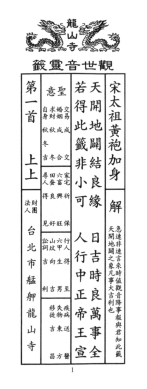

time: 4.1 s (started: 2024-12-14 10:17:08 +00:00)


In [ ]:
# Test image download from 艋舺龍山寺 website
n = 1
source = PAGE_SOURCE_MAP['艋舺龍山寺']

img_url = source['img_url'].format(n)
img_fname = os.path.join(source['img_folder'], source['img_fname'].format(n))
print(img_url)

data = fetch_image(id=n-1, url=img_url, filename=img_fname)
plt.imshow(plt.imread(img_fname))
plt.axis('off')
plt.show()

# 3.Aggregation

Aggregate all text and image data into centeralized data source.
取得籤詩所有關聯的圖文資料


## Text


In [ ]:
# INSERT mode
ids = range(TOTAL_LOTS)
# ids = []  # on demand
all_chances = []

for id in ids:
    n = id + 1
    src = PAGE_SOURCE_MAP['艋舺龍山寺']
    data = fetch_page_source1(id=id, url=src['page_url'].format(n))

    src = PAGE_SOURCE_MAP['周公靈簽']
    data_ext = fetch_page_source3(id=id, url=src['page_url'].format(n))
    data.update(data_ext)

    src = PAGE_SOURCE_MAP['解籤閣']
    data_ext = fetch_page_source4(id=id, url=src['page_url'].format(n))
    data.update(data_ext)

    all_chances.append(data)

print(len(all_chances))
pprint(all_chances[0] if len(all_chances) > 0 else None)

0
None


In [ ]:
# UPDATE mode
# ids = [x['id'] for x in all_chances]
ids = []  # on demand

for id in ids:
    data = all_chances[id]
    n = id + 1

    # src = PAGE_SOURCE_MAP['艋舺龍山寺']
    # data_ext = fetch_page_source1(id=id, url=src['page_url'].format(n))
    # data.update(data_ext)

    # src = PAGE_SOURCE_MAP['周公靈簽']
    # data_ext = fetch_page_source3(id=id, url=src['page_url'].format(n))
    # data.update(data_ext)

    # src = PAGE_SOURCE_MAP['解籤閣']
    # data_ext = fetch_page_source4(id=id, url=src['page_url'].format(n))
    # data.update(data_ext)

In [ ]:
n = 48
all_chances[n-1] if len(all_chances) > 0 else None

## Images


In [ ]:
# !unzip -o 'images-觀音100籤詩.zip'

Archive:  images-觀音100籤詩.zip
  inflating: images/fortune_87.jpg   
  inflating: images/fortune_96.jpg   
  inflating: images/fortune_11.jpg   
  inflating: images/fortune_53.jpg   
  inflating: images/fortune_51.jpg   
  inflating: images/fortune_73.jpg   
  inflating: images/fortune_6.jpg    
  inflating: images/fortune_33.jpg   
  inflating: images/fortune_90.jpg   
  inflating: images/fortune_43.jpg   
  inflating: images/fortune_30.jpg   
  inflating: images/fortune_60.jpg   
  inflating: images/fortune_45.jpg   
  inflating: images/fortune_52.jpg   
  inflating: images/fortune_8.jpg    
  inflating: images/fortune_10.jpg   
  inflating: images/fortune_15.jpg   
  inflating: images/fortune_46.jpg   
  inflating: images/fortune_34.jpg   
  inflating: images/fortune_62.jpg   
  inflating: images/fortune_25.jpg   
  inflating: images/fortune_31.jpg   
  inflating: images/fortune_100.jpg  
  inflating: images/fortune_95.jpg   
  inflating: images/fortune_27.jpg   
  inflating: images/f

In [ ]:
len([x for x in all_chances if not x['img_fname']])

0

In [ ]:
# Start downloading images ...
if len(all_chances) == TOTAL_LOTS:
    for data in [x for x in all_chances if not x['img_fname']]:
        src = PAGE_SOURCE_MAP['艋舺龍山寺']
        id = data['id']
        n = id + 1
        img_url = src['img_url'].format(n)
        img_fname = os.path.join(src['img_folder'], src['img_fname'].format(n))
        data['img_url'] = img_url

        result = fetch_image(
            id=id,
            url=img_url,
            filename=img_fname,
            mock=True  # True: 不下載圖片
        )
        if result:
            data['img_fname'] = img_fname

In [ ]:
len([x for x in all_chances if not x['img_fname']])

0

In [ ]:
# !zip -r images.zip images

## Data Cleaning


In [ ]:
# Preview Poem #23 in data source.
pprint(all_chances[22] if len(all_chances) > 0 else None)

{'id': 22,
 'img_fname': 'images/fortune_23.jpg',
 'img_url': 'https://www.lungshan.org.tw/fortune_sticks/images/023.jpg',
 'url1': 'https://www.lungshan.org.tw/fortune_sticks/page.php?FS_ID=23',
 'url2': 'https://www.0961223888.com/kannon/Kannon23.htm',
 'url3': 'https://www.golla.tw/chouqian/zhougong/23.html',
 'url4': 'https://www.sheup.org/winfo/7/872.html',
 '吉凶': '中籤',
 '宮位': '巳宮',
 '淺釋': '想要藉由桂樹爬上仙宮去，只怕天門不會就此為你開放;把所求的計畫降低標準，自有高人送上山頂，指引通達的途徑。',
 '籤名': '第二十三首',
 '籤詩': ['欲攀仙桂蟾宮去', '豈慮天門不放開', '謀望一般音信好', '高人自送嶺頭來'],
 '聖意': {'交易': '合',
        '公訟': '虧',
        '六甲': '作福',
        '六畜': '不利',
        '失物': '未指示',
        '婚姻': '阻',
        '家宅': '欠安',
        '尋人': '難',
        '山墳': '舊吉',
        '求財': '遂意',
        '田蠶': '不利',
        '疾病': '安',
        '移徙': '欠吉',
        '自身': '作福',
        '行人': '有危'},
 '解曰': '商賈利益，行藏無危，病安訟理，盡可施為。此簽望仙扳桂之象，凡事必遇貴人。',
 '詩名': '孫策以璽借袁兵',
 '詩意': '此卦手扳仙桂之象。凡事必有貴人也。',
 '詩運': '上平',
 '詳解': '此籤有"拋磚引玉"之意。提醒當事人，施比受有福。在人與人的交往中，應主動而真誠的關心他人、了解他人的需要，在自己的能力範圍之內，盡

In [ ]:
import re


def convert詩運to吉凶(text: str, default: str = "中籤") -> str:
    first = text[1] if text else default
    match first:
        case "大": return "上籤"
        case "上": return "上籤"
        case "中": return "中籤"
        case "平": return "中籤"
        case "下": return "下籤"
        case _:
            return default


offset_id = min([v["id"] for v in all_chances])
print(f"{offset_id=}")  # update to zero-based index


# # 移除特殊字元, 格式化資料
for id, v in enumerate(all_chances):
    詩名 = v["詩名"].split("：")[-1]
    詩運 = v["詩運"] or ""
    if not 詩運 or (詩運 not in LOT_RESULTs):
        詩運 = UNKNOWN_LOT_RESULT

    吉凶 = v["吉凶"]
    if 詩運 == "大吉" and 吉凶 != "上籤":
        吉凶 = "上籤"

    詳解 = re.sub(r"[^\S ]+", " ", v["詳解"]).replace("”", '"').replace("“", '"')
    v.update({"id": v["id"] - offset_id})
    v.update({"詩名": 詩名})
    v.update({"詩運": 詩運})
    v.update({"吉凶": 吉凶})
    v.update({"詳解": 詳解})

    print(f"{id}=={v['id']}", f"content=【{v['籤名']} {詩運} {吉凶}】{v['詳解'][:20]}")

offset_id=0
0==0 content=【第一首 上上 上籤】此籤有"謀事在人"之意。提醒當事人，未雨
1==1 content=【第二首 中 下籤】此籤有"守時待勢"之意。意味當事人，隨遇
2==2 content=【第三首 __ 下籤】此籤有"束手無策"之意。奉勸當事人，勿舉
3==3 content=【第四首 中中 上籤】此籤有"歷久彌堅"之意。意味當事人，不改
4==4 content=【第五首 中平 中籤】此籤有"休戚相關"之意。意味當事人，推誠
5==5 content=【第六首 中平 中籤】此籤有"見機行事"之意。意味當事人，智勇
6==6 content=【第七首 __ 下籤】此籤有"一念之差"之意。奉勸當事人，三思
7==7 content=【第八首 上上 上籤】此籤有"事在人為"之意。鼓勵當事人，自強
8==8 content=【第九首 上上 上籤】此籤有"雜不如精"之意。提醒當事人，凡事
9==9 content=【第十首 __ 中籤】此籤有"枉費心機"之意。奉勸當事人，凡事
10==10 content=【第十一首 上上 上籤】此籤有"見機行事"之意。提醒當事人，凡事
11==11 content=【第十二首 上上 上籤】此籤有"勇往直前"之意。鼓勵當事人，百折
12==12 content=【第十三首 上上 中籤】此籤有"謙讓未遑"之意。提醒當事人，施恩
13==13 content=【第十四首 大吉 上籤】此籤有"公私分明"之意。提醒當事人，豁達
14==14 content=【第十五首 __ 中籤】此籤有"自食惡果"之意。奉勸當事人，勿一
15==15 content=【第十六首 中上 中籤】此籤有"忠言逆耳"之意。意味當事人，飲水
16==16 content=【第十七首 中 中籤】此籤有"居心叵測"之意。奉勸當事人，勿心
17==17 content=【第十八首 上上 上籤】此籤有"言之成理"之意。提醒當事人，勿過
18==18 content=【第十九首 中 中籤】此籤有"自甘墮落"之意。意味當事人，勿隨
19==19 content=【第二十首 上上 中籤】此籤有"苦盡甘來"之意。鼓勵當事人，堅持
20==20 content=【第二十一首 上吉 上籤】此籤有"一探究竟"之意。鼓勵當事人，保持
21==21 conte

In [ ]:
# Poem distribution
from collections import Counter

lot_result_count_map = dict(Counter([v['詩運'] for v in all_chances]))
sum(lot_result_count_map.values()), len(
    lot_result_count_map), lot_result_count_map

In [ ]:
# Check again after data cleaned up.
print(all_chances[0].get('籤名'), ': ', all_chances[0].get('詳解'))
pprint(all_chances[22])

In [ ]:
current_lot_groups = list(set([v['吉凶'] for v in all_chances]))
current_lot_names = list(set([v['籤名'] for v in all_chances]))
current_lot_results = list(set([v['詩運'] for v in all_chances]))

print(f'{len(current_lot_groups)=}', current_lot_groups)
print(f'{len(current_lot_names)=}', current_lot_names)
print(f'{len(current_lot_results)=}', current_lot_results)

[f"{v['籤名']}-{v['詩名']} - {v['詩運']} - {v['吉凶']}" for v in all_chances]

## Export to all_chances.json


In [ ]:
all_chances[0]['詩名']

'宋太祖黃袍加身'

In [ ]:
# Overwrite all_chances.json
all_chances_file = 'all_chances.json'
if all_chances:
    with open(all_chances_file, 'w', encoding='utf-8') as f:
        json.dump(all_chances, f, indent=4, ensure_ascii=False)
    print(f'Stored {len(all_chances)} records to {all_chances_file}')

Stored 100 records to all_chances.json


## Import all_chances.json


In [ ]:
import json

all_chances_file = 'all_chances.json'
all_chances = []
# Read all_chances.json, please upload to colab first.
with open(all_chances_file, 'r', encoding='utf8') as f:
    all_chances = json.load(f)

print(f'Loaded {len(all_chances)} records from {all_chances_file}')

Loaded 100 records from all_chances.json
